# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Solar Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\solar_production_dataset.csv')

data.head()

,Country,Date,Value,Daylight,Temperature,GHI,DNI
0,Australia,2023-03-01,4055.6634,734.69403,26.204160,894897.94,693884.56
1,Australia,2023-02-01,4466.4801,778.22370,27.318323,997130.10,756902.75
2,Australia,2023-01-01,4967.0119,812.18915,27.128540,1009778.60,739408.44
3,Australia,2022-12-01,5179.1465,822.62040,26.521873,1087540.60,817223.80
4,Australia,2022-11-01,4548.5315,801.65320,23.784800,1055200.00,791037.10


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

solar_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'solar' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Daylight', 'Temperature', 'GHI', 'DNI']
    ]
    
    # Store the filtered data in the dictionary
    solar_production_data[country] = country_energy_production.reset_index(drop=True)

solar_production_data['Australia']

,Date,Value,Daylight,Temperature,GHI,DNI
0,2023-03-01,4055.6634,734.69403,26.204160,894897.94,693884.56
1,2023-02-01,4466.4801,778.22370,27.318323,997130.10,756902.75
2,2023-01-01,4967.0119,812.18915,27.128540,1009778.60,739408.44
3,2022-12-01,5179.1465,822.62040,26.521873,1087540.60,817223.80
4,2022-11-01,4548.5315,801.65320,23.784800,1055200.00,791037.10
...,...,...,...,...,...,...
154,2010-05-01,19.5230,652.28723,18.453670,593292.40,445716.78
155,2010-04-01,26.8110,689.48145,23.213960,720994.44,539130.44
156,2010-03-01,37.2520,734.45386,25.565712,885022.70,675000.75
157,2010-02-01,38.8840,778.00037,27.760725,965296.10,715466.20


# Resample to daily data

In [4]:
# hypro_production_data
for country_data in solar_production_data:
    
    # set time as the index
    solar_production_data[country_data]['Date'] = pd.to_datetime(solar_production_data[country_data]['Date'])
    solar_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    solar_production_data[country_data]['Value'] = (solar_production_data[country_data]['Value']/
                                                    solar_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = solar_production_data[country_data].resample('D').interpolate('linear')
    solar_production_data[country_data] = daily_data
    
solar_production_data['Australia']

,Value,Daylight,Temperature,GHI,DNI
Date,,,,,
2010-01-01,1.587613,812.054750,28.175785,1.066227e+06,806248.500000
2010-01-02,1.581197,810.956222,28.162396,1.062971e+06,803320.038710
2010-01-03,1.574781,809.857693,28.149007,1.059715e+06,800391.577419
2010-01-04,1.568365,808.759165,28.135618,1.056459e+06,797463.116129
2010-01-05,1.561949,807.660636,28.122229,1.053204e+06,794534.654839
...,...,...,...,...,...
2023-02-25,134.926322,740.912554,26.363326,9.095025e+05,702887.158571
2023-02-26,133.901705,739.357923,26.323535,9.058514e+05,700636.508929
2023-02-27,132.877087,737.803292,26.283743,9.022002e+05,698385.859286


# Model Building

### Split train and test data

In [5]:
data = solar_production_data['Australia']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

               Value    Daylight  Temperature           GHI            DNI
Date                                                                      
2010-01-01  1.587613  812.054750    28.175785  1.066227e+06  806248.500000
2010-01-02  1.581197  810.956222    28.162396  1.062971e+06  803320.038710
2010-01-03  1.574781  809.857693    28.149007  1.059715e+06  800391.577419
2010-01-04  1.568365  808.759165    28.135618  1.056459e+06  797463.116129
2010-01-05  1.561949  807.660636    28.122229  1.053204e+06  794534.654839
(4019, 5)

                 Value    Daylight  Temperature           GHI            DNI
Date                                                                        
2021-01-01  104.867332  811.776250    27.552252  1.054509e+06  784853.060000
2021-01-02  104.684103  810.672155    27.515393  1.051203e+06  782109.741935
2021-01-03  104.500875  809.568060    27.478535  1.047897e+06  779366.423871
2021-01-04  104.317646  808.463965    27.441676  1.044592e+06  776623.105806
20

## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (0,2,1)(0,1,0)[365] 

#### Figure below show the result from R:
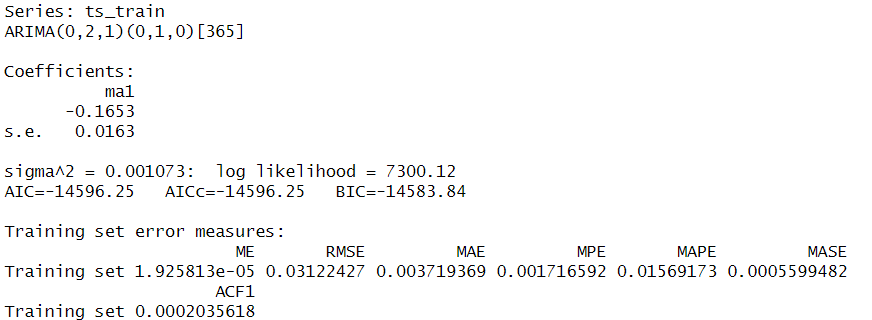

In [51]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
aus_solar_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\aus_solar_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: This is forecast 8.21 
  Use suppressPackageStartupMessages() to eliminate package startup messages.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [52]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(aus_solar_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test['Value'].values))
mse = mean_squared_error(predictions.rx('mean')[0], test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  45.54012540725449
Mean Squared Error:  2727.2467227727775
Root Mean Squared Error:  52.2230478119841


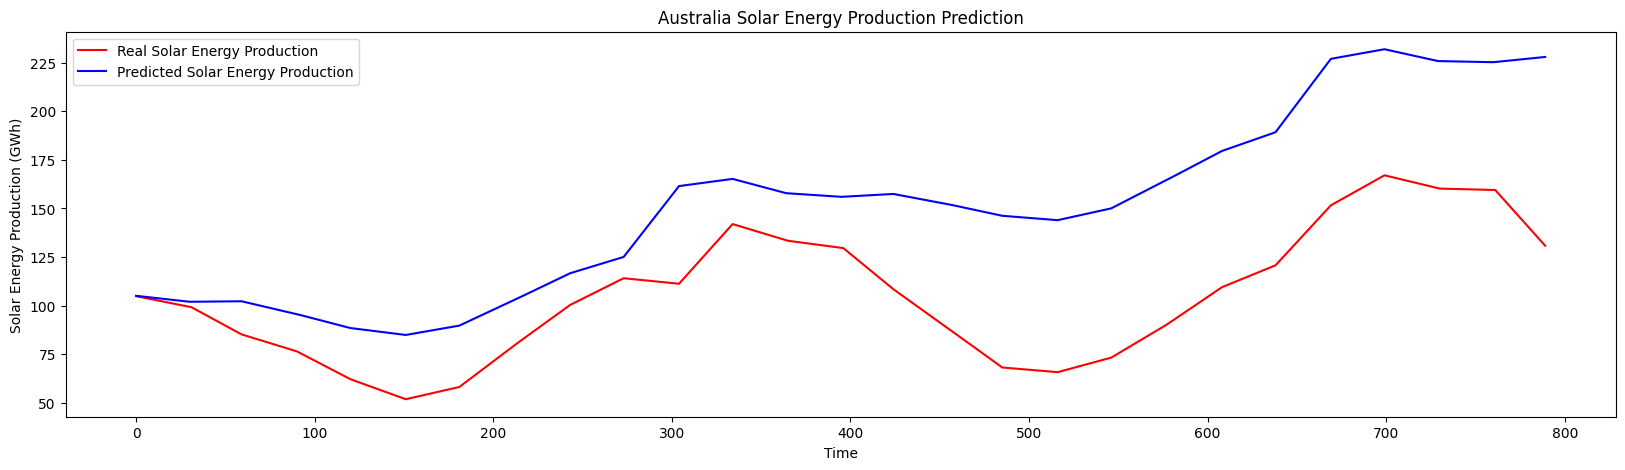

In [53]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Solar Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Solar Energy Production')
plt.title('Australia Solar Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [54]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [86]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(3654, 365) (3654,)


In [87]:
# Build and Train the SVM Model
aus_daily_svr = SVR(kernel='linear',gamma=0.5, C=0.1, epsilon = 0.01) # Specify hyperparameters
aus_daily_svr.fit(x_train, y_train)

SVR(C=0.1, epsilon=0.01, gamma=0.5, kernel='linear')

In [88]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Solar Energy Production
svr_y_pred = aus_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [89]:
print(inputs)

[[0.59090173]
 [0.58963013]
 [0.58835853]
 ...
 [1.16873245]
 [1.15968417]
 [1.15063588]]


In [90]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  1.983529328356623
Mean Squared Error:  6.0814245499475685
Root Mean Squared Error:  2.4660544499154047


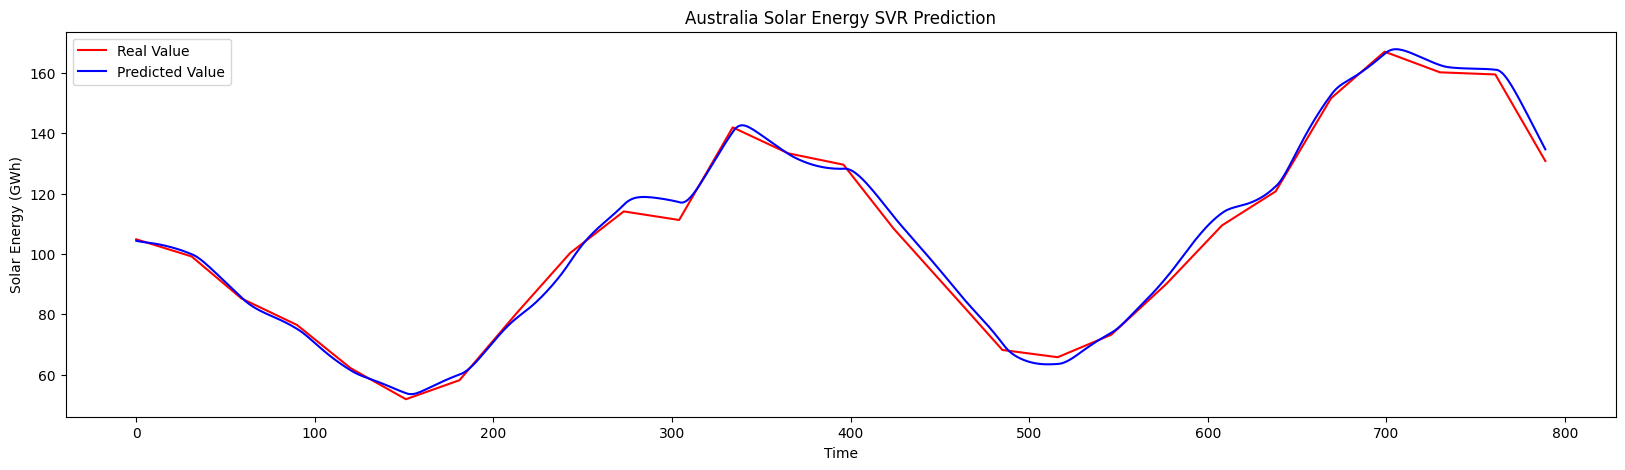

In [91]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('Australia Solar Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Daily

In [61]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [62]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [19]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
aus_daily_gru = Sequential()
aus_daily_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
aus_daily_gru.add(GRU(units=64))
aus_daily_gru.add(Dense(1, activation='linear'))

aus_daily_gru.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
aus_daily_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 122s 594ms/step - loss: 0.0042
Epoch 2/100
115/115 [==============================] - 63s 552ms/step - loss: 2.6849e-05
Epoch 3/100
115/115 [==============================] - 69s 604ms/step - loss: 2.3256e-05
Epoch 4/100
115/115 [==============================] - 71s 615ms/step - loss: 1.9776e-05
Epoch 5/100
115/115 [==============================] - 83s 726ms/step - loss: 1.8526e-05
Epoch 6/100
115/115 [==============================] - 84s 732ms/step - loss: 1.6808e-05
Epoch 7/100
115/115 [==============================] - 78s 684ms/step - loss: 1.5452e-05
Epoch 8/100
115/115 [==============================] - 79s 685ms/step - loss: 1.5002e-05
Epoch 9/100
115/115 [==============================] - 85s 738ms/step - loss: 1.5341e-05
Epoch 10/100
115/115 [==============================] - 79s 687ms/step - loss: 1.2276e-05
Epoch 11/100
115/115 [==============================] - 81s 705ms/step - loss: 9.8823e-06
Epoch 12/100
115/115 [

115/115 [==============================] - 89s 776ms/step - loss: 5.0986e-06
Epoch 93/100
115/115 [==============================] - 83s 718ms/step - loss: 1.7321e-06
Epoch 94/100
115/115 [==============================] - 109s 953ms/step - loss: 2.3022e-05
Epoch 95/100
115/115 [==============================] - 116s 1s/step - loss: 7.6319e-07
Epoch 96/100
115/115 [==============================] - 114s 991ms/step - loss: 5.3242e-07
Epoch 97/100
115/115 [==============================] - 109s 946ms/step - loss: 9.2490e-07
Epoch 98/100
115/115 [==============================] - 107s 928ms/step - loss: 9.9822e-07
Epoch 99/100
115/115 [==============================] - 101s 879ms/step - loss: 1.0486e-06
Epoch 100/100
115/115 [==============================] - 104s 906ms/step - loss: 8.1049e-07


In [63]:
# Getting the predicted value
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

gru_y_pred = aus_daily_gru.predict(X_test)
gru_y_pred = sc.inverse_transform(gru_y_pred)

25/25 [==============================] - 24s 288ms/step


In [64]:
print("Mean Absolute Error: ", mean_absolute_error(gru_y_pred, test['Value'].values))
mse = mean_squared_error(gru_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  0.3185400201890481
Mean Squared Error:  0.2519512465541274
Root Mean Squared Error:  0.5019474539771344


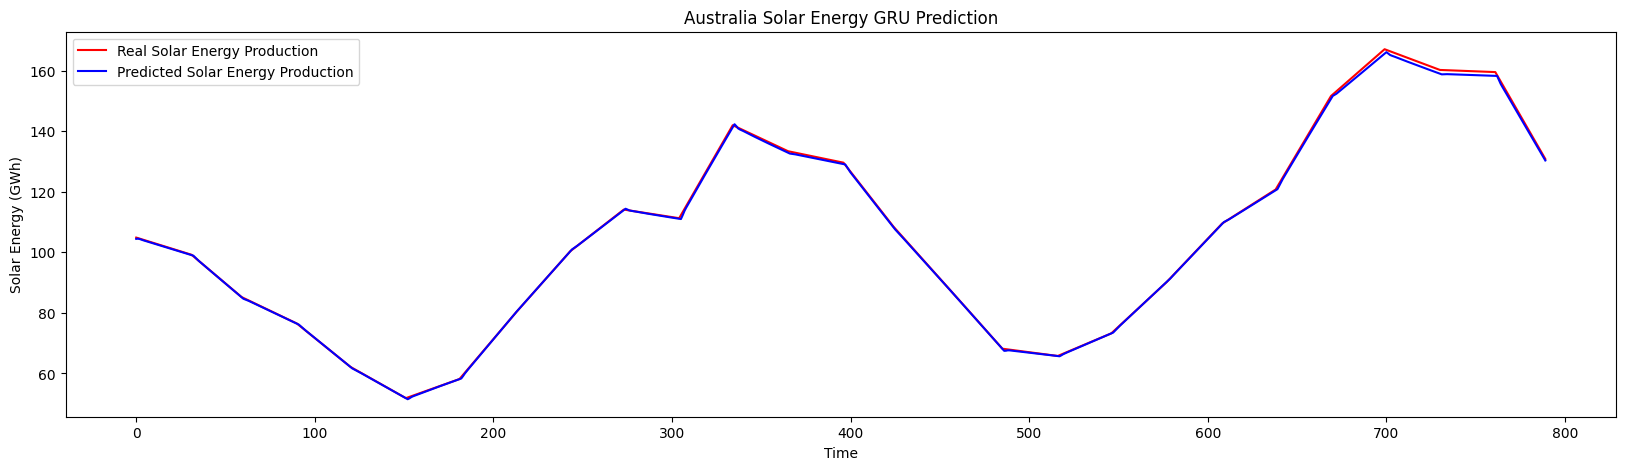

In [65]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Solar Energy Production')
plt.plot(gru_y_pred, color = 'blue', label = 'Predicted Solar Energy Production')
plt.title('Australia Solar Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [66]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.00932965]
 [0.00927299]
 [0.00921633]
 ...
 [0.92645358]
 [0.9239175 ]
 [0.92138141]]
(4019, 1)


In [67]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [68]:
print(X_train)
X_train.shape

[[0.00932965 0.00927299 0.00921633 ... 0.0454525  0.04546144 0.04547039]
 [0.00927299 0.00921633 0.00915967 ... 0.04546144 0.04547039 0.04547933]
 [0.00921633 0.00915967 0.00910302 ... 0.04547039 0.04547933 0.04527656]
 ...
 [0.59635078 0.59344492 0.59217332 ... 0.93406183 0.93152575 0.92898966]
 [0.59344492 0.59217332 0.59090173 ... 0.93152575 0.92898966 0.92645358]
 [0.59217332 0.59090173 0.58963013 ... 0.92898966 0.92645358 0.9239175 ]]


(3654, 365)

In [69]:
print(y_train)
y_train.shape

[0.04547933 0.04527656 0.04507379 ... 0.92645358 0.9239175  0.92138141]


(3654,)

In [70]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [29]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [30]:
# Initialising the RNN
aus_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
aus_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
aus_daily_uni_lstm.add(Dropout(0.2))

aus_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
aus_daily_uni_lstm.add(Dropout(0.2))

aus_daily_uni_lstm.add(LSTM(units = 64))
aus_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
aus_daily_uni_lstm.add(Dense(units = 1))

In [31]:
# Compiling the RNN
aus_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
aus_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
115/115 [==============================] - 234s 1s/step - loss: 0.0035
Epoch 2/100
115/115 [==============================] - 126s 1s/step - loss: 0.0011
Epoch 3/100
115/115 [==============================] - 148s 1s/step - loss: 9.9282e-04
Epoch 4/100
115/115 [==============================] - 163s 1s/step - loss: 7.7521e-04
Epoch 5/100
115/115 [==============================] - 144s 1s/step - loss: 9.4651e-04
Epoch 6/100
115/115 [==============================] - 114s 995ms/step - loss: 6.5291e-04
Epoch 7/100
115/115 [==============================] - 121s 1s/step - loss: 6.8436e-04
Epoch 8/100
115/115 [==============================] - 117s 1s/step - loss: 6.2168e-04
Epoch 9/100
115/115 [==============================] - 116s 1s/step - loss: 6.2568e-04
Epoch 10/100
115/115 [==============================] - 121s 1s/step - loss: 4.5770e-04
Epoch 11/100
115/115 [==============================] - 116s 1s/step - loss: 4.6939e-04
Epoch 12/100
115/115 [========================

115/115 [==============================] - 112s 976ms/step - loss: 2.5573e-04
Epoch 94/100
115/115 [==============================] - 117s 1s/step - loss: 2.8671e-04
Epoch 95/100
115/115 [==============================] - 116s 1s/step - loss: 3.1622e-04
Epoch 96/100
115/115 [==============================] - 112s 969ms/step - loss: 2.8229e-04
Epoch 97/100
115/115 [==============================] - 118s 1s/step - loss: 2.7607e-04
Epoch 98/100
115/115 [==============================] - 115s 1000ms/step - loss: 2.9744e-04
Epoch 99/100
115/115 [==============================] - 122s 1s/step - loss: 2.6937e-04
Epoch 100/100
115/115 [==============================] - 119s 1s/step - loss: 2.4011e-04


In [32]:
test[['Value']].shape

(790, 1)

In [71]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = aus_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 14s 166ms/step


In [72]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test['Value'].values))
mse = mean_squared_error(uni_lstm_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  3.433978711807624
Mean Squared Error:  37.170619933331054
Root Mean Squared Error:  6.096771271200114


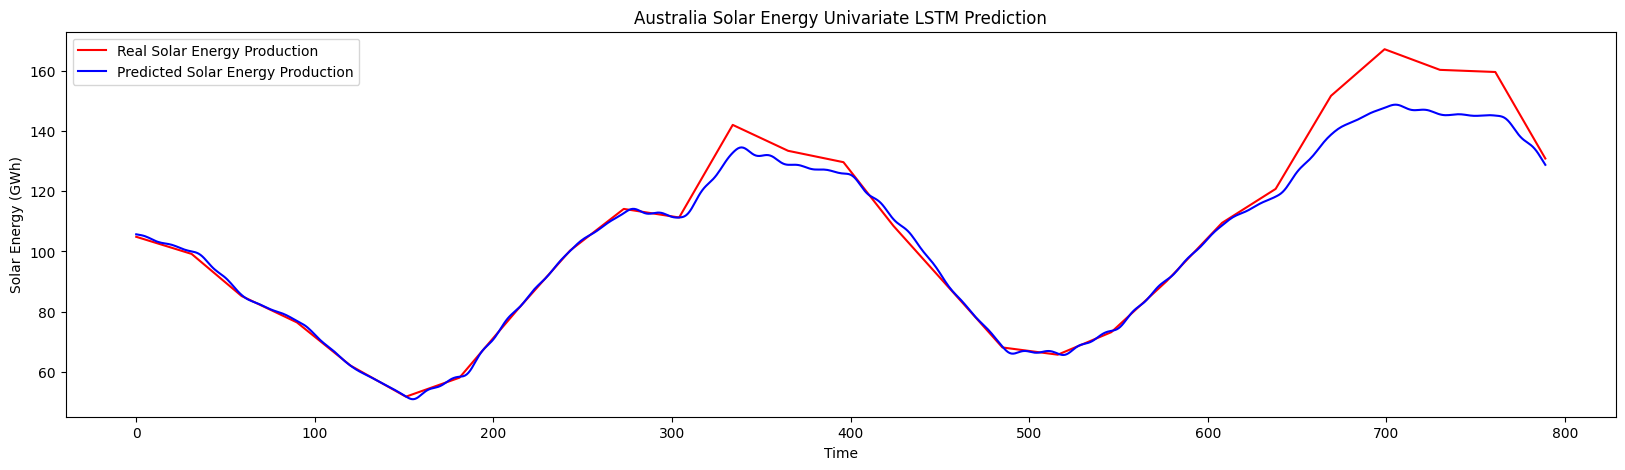

In [73]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Solar Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Solar Energy Production')
plt.title('Australia Solar Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [74]:
data = solar_production_data['Australia']

data.shape

(4808, 5)

In [75]:
X = data[['Daylight', 'Temperature', 'GHI', 'DNI', 'Value']]
y = data[['Value']]

X.head()

,Daylight,Temperature,GHI,DNI,Value
Date,,,,,
2010-01-01,812.054750,28.175785,1.066227e+06,806248.500000,1.587613
2010-01-02,810.956222,28.162396,1.062971e+06,803320.038710,1.581197
2010-01-03,809.857693,28.149007,1.059715e+06,800391.577419,1.574781
2010-01-04,808.759165,28.135618,1.056459e+06,797463.116129,1.568365
2010-01-05,807.660636,28.122229,1.053204e+06,794534.654839,1.561949


In [76]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [77]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [78]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(4019, 5)
(790, 5)

(4019, 1)
(790, 1)


In [79]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

(3654, 365, 5)


In [80]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

aus_daily_multi_lstm = Sequential()
aus_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
aus_daily_multi_lstm.add(Dropout(0.2))
aus_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
aus_daily_multi_lstm.add(Dropout(0.2))
aus_daily_multi_lstm.add(LSTM(units = 64))
aus_daily_multi_lstm.add(Dropout(0.2))
aus_daily_multi_lstm.add(Dense(1))

In [46]:
aus_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

aus_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 156s 846ms/step - loss: 0.0068
Epoch 2/100
115/115 [==============================] - 105s 912ms/step - loss: 0.0014
Epoch 3/100
115/115 [==============================] - 113s 980ms/step - loss: 0.0011
Epoch 4/100
115/115 [==============================] - 110s 955ms/step - loss: 9.8786e-04
Epoch 5/100
115/115 [==============================] - 114s 994ms/step - loss: 0.0012
Epoch 6/100
115/115 [==============================] - 121s 1s/step - loss: 6.7276e-04
Epoch 7/100
115/115 [==============================] - 107s 928ms/step - loss: 9.1389e-04
Epoch 8/100
115/115 [==============================] - 118s 1s/step - loss: 7.9133e-04
Epoch 9/100
115/115 [==============================] - 122s 1s/step - loss: 6.5059e-04
Epoch 10/100
115/115 [==============================] - 134s 1s/step - loss: 5.7547e-04
Epoch 11/100
115/115 [==============================] - 129s 1s/step - loss: 6.2713e-04
Epoch 12/100
115/115 [=================

115/115 [==============================] - 97s 843ms/step - loss: 2.7169e-04
Epoch 93/100
115/115 [==============================] - 95s 824ms/step - loss: 2.8700e-04
Epoch 94/100
115/115 [==============================] - 94s 820ms/step - loss: 2.9072e-04
Epoch 95/100
115/115 [==============================] - 94s 818ms/step - loss: 3.1639e-04
Epoch 96/100
115/115 [==============================] - 96s 834ms/step - loss: 2.8445e-04
Epoch 97/100
115/115 [==============================] - 98s 850ms/step - loss: 2.6017e-04
Epoch 98/100
115/115 [==============================] - 89s 771ms/step - loss: 2.6589e-04
Epoch 99/100
115/115 [==============================] - 78s 677ms/step - loss: 2.4944e-04
Epoch 100/100
115/115 [==============================] - 77s 669ms/step - loss: 3.0542e-04


In [81]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)
print(inputs.shape)
len(X_test)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))

multi_lstm_y_pred = aus_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)
hist_value = y_scaler.inverse_transform(y_train)
multi_lstm_y_pred

(1155, 5)
25/25 [==============================] - 33s 230ms/step


array([[106.915764],
       [106.73737 ],
       [106.5602  ],
       [106.39106 ],
       [106.2335  ],
       [106.08938 ],
       [105.95857 ],
       [105.839424],
       [105.72926 ],
       [105.62487 ],
       [105.52301 ],
       [105.420685],
       [105.31546 ],
       [105.20555 ],
       [105.089836],
       [104.96783 ],
       [104.83955 ],
       [104.70539 ],
       [104.566025],
       [104.422195],
       [104.27465 ],
       [104.12411 ],
       [103.97111 ],
       [103.8161  ],
       [103.65936 ],
       [103.501045],
       [103.341225],
       [103.17987 ],
       [103.01695 ],
       [102.85237 ],
       [102.686035],
       [102.51788 ],
       [102.347916],
       [102.16917 ],
       [101.96916 ],
       [101.73665 ],
       [101.46343 ],
       [101.14522 ],
       [100.781425],
       [100.37462 ],
       [ 99.92951 ],
       [ 99.45209 ],
       [ 98.94864 ],
       [ 98.425   ],
       [ 97.8862  ],
       [ 97.33602 ],
       [ 96.77703 ],
       [ 96.2

In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  10.40741401009439
Mean Squared Error:  287.1708349275195
Root Mean Squared Error:  16.946115629474487


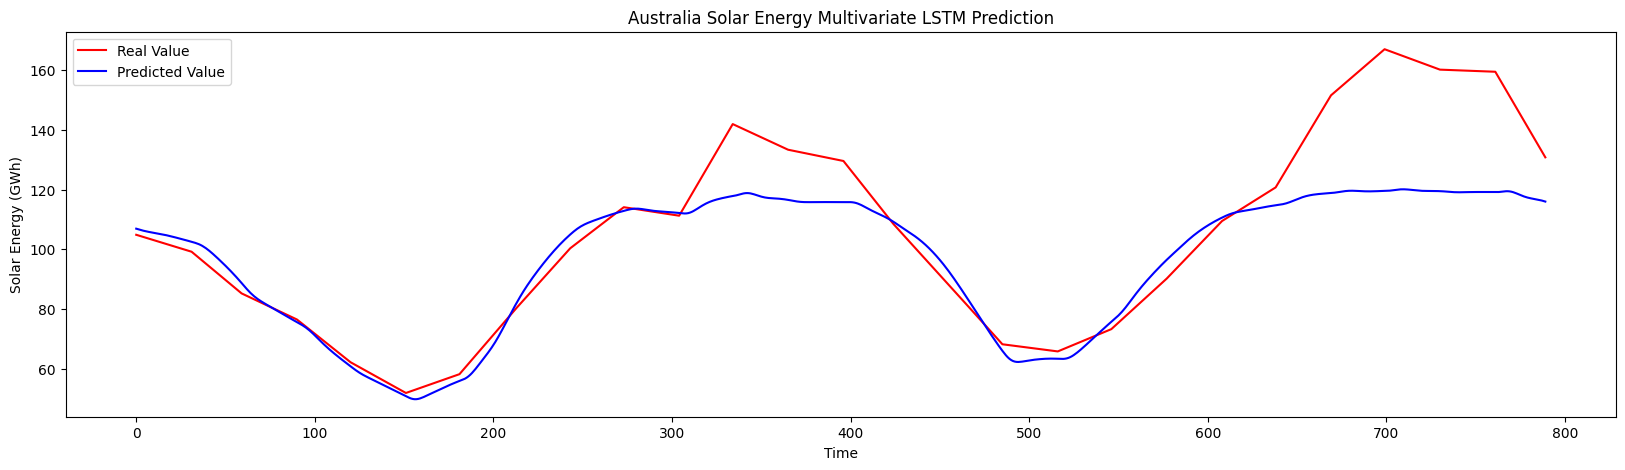

In [83]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('Australia Solar Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

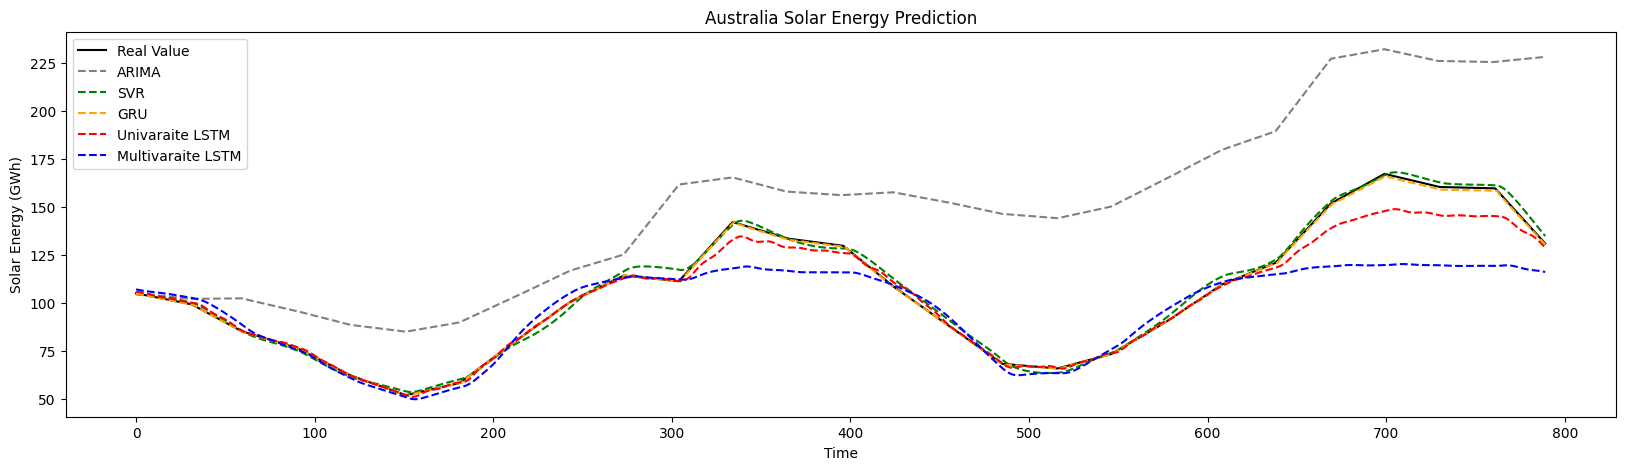

In [92]:
# Overview

# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(gru_y_pred, color='orange', linestyle='--', label='GRU')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('Australia Solar Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [50]:
aus_daily_gru.save("aus_solar_best_gru.h5")

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
